# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [2]:
import warnings
from typing import Iterable, Tuple

import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"120_tysyach_anekdotov\anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [4]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [5]:
cut_text = cut_data(text)

In [6]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [7]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [8]:
def encode(sentence, vocab):
    return [vocab[sym] for sym in sentence]# List of ints 

def decode(tokens, vocab):
    return [vocab[tok] for tok in tokens]# list of strings

In [9]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

In [10]:
encoded = encode(cut_text[0], char2int)
encoded

[144,
 183,
 110,
 6,
 80,
 183,
 56,
 203,
 88,
 41,
 87,
 152,
 129,
 110,
 105,
 56,
 155,
 152,
 183,
 56,
 198,
 110,
 183,
 25,
 183,
 56,
 109,
 27,
 46,
 40,
 154,
 183,
 109,
 56,
 154,
 88,
 78,
 129,
 40,
 88,
 87,
 152,
 198,
 179,
 56,
 198,
 88,
 41,
 129,
 41,
 129,
 56,
 133,
 87,
 154,
 152,
 40,
 88,
 110,
 6,
 154,
 1,
 41,
 129,
 56,
 80,
 110,
 88,
 25,
 129,
 9,
 88,
 41,
 129,
 84,
 56,
 77,
 88,
 80,
 56,
 25,
 198,
 87,
 56,
 27,
 40,
 183,
 169,
 171,
 41,
 88,
 154,
 183,
 105,
 56,
 78,
 110,
 129,
 154,
 73]

In [11]:
decoded = decode(encoded, int2char)
decoded

['Т',
 'о',
 'л',
 'ь',
 'к',
 'о',
 ' ',
 'з',
 'а',
 'м',
 'е',
 'т',
 'и',
 'л',
 ',',
 ' ',
 'ч',
 'т',
 'о',
 ' ',
 'с',
 'л',
 'о',
 'в',
 'о',
 ' ',
 '"',
 'п',
 '@',
 'р',
 'н',
 'о',
 '"',
 ' ',
 'н',
 'а',
 'б',
 'и',
 'р',
 'а',
 'е',
 'т',
 'с',
 'я',
 ' ',
 'с',
 'а',
 'м',
 'и',
 'м',
 'и',
 ' ',
 'ц',
 'е',
 'н',
 'т',
 'р',
 'а',
 'л',
 'ь',
 'н',
 'ы',
 'м',
 'и',
 ' ',
 'к',
 'л',
 'а',
 'в',
 'и',
 'ш',
 'а',
 'м',
 'и',
 '.',
 ' ',
 'К',
 'а',
 'к',
 ' ',
 'в',
 'с',
 'е',
 ' ',
 'п',
 'р',
 'о',
 'д',
 'у',
 'м',
 'а',
 'н',
 'о',
 ',',
 ' ',
 'б',
 'л',
 'и',
 'н',
 '!']

In [12]:
# Проверьте, что энеодинг и декодинг работают

Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [13]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    words_one_hot = torch.zeros(
        (int_words.numel(), vocab_size), device=int_words.device, dtype=int_words.dtype
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten()] = 1
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    # your code: make from int one hot vector for each element of input tensor. Size bxseq_len -> b x seq_len x vocab_size
    return words_one_hot

Проверьте ваш код.

In [14]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [15]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        n = len(self.int2char)
        self.char2int[symbol] = n
        self.int2char[n] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char)
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars]# List of ints 

    def idx_to_str(self, idx):
        return [self.int2char[sym] for sym in idx]# List of ints 

    def encode(self, chars, eos=True):
        if eos:
            chars = ['<bos>'] + list(chars) + ['<eos>']
        else:
            chars = ['<bos>'] + list(chars)
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(chars)


In [16]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 256):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
        
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        encoded = self.tokenizer.encode(self.cut_text[item])[:self.max_len]
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)
        padded[:len(encoded)] = torch.tensor(encoded)
        # padded = encoded + torch.zeros()
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        return padded, len(encoded)

# Optionally add new methods to your dataset class

In [17]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [18]:
class CharRNN(nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 512) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        # Define the LSTM, dropout, and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # Pack the padded sequence
        x = self.encoder(x)
        outputs, hidden = self.rnn(x)
        # Pass through a dropout layer and fully connected layer
        outputs = self.dropout(outputs)
        outputs = self.decoder(outputs)
        
        return outputs, hidden

    def inference(self, prefix="", device="cpu"):
        # Encode the prefix into token IDs
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device)
        

        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens[0])):
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break

        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [19]:
seq_length = 256
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.001

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [20]:
def training_step(model: CharRNN, train_batch: Tuple[torch.Tensor, torch.Tensor],
                  vocab_size: int, criterion: nn.Module, optimizer, device="cpu") -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    outputs, _ = model(inputs[:, :-1], lengths)

    # Переформатирование выходов и целевых меток для расчета функции потерь
    outputs = outputs.view(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(outputs, targets)

    # Обратный проход
    loss.backward()

    # Шаг оптимизации
    optimizer.step()
    return loss.item()

Инициализируйте модель, функцию потерь и оптимизатор.

In [21]:
model = CharRNN(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob)
hidden = None
criterion = nn.CrossEntropyLoss(ignore_index=214)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [22]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
model = model.to(device)

In [25]:
optimizer.param_groups[0]['lr'] = 1e-3

In [26]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [28]:
# model.load_state_dict(torch.load("./rnn.pt"))

<All keys matched successfully>

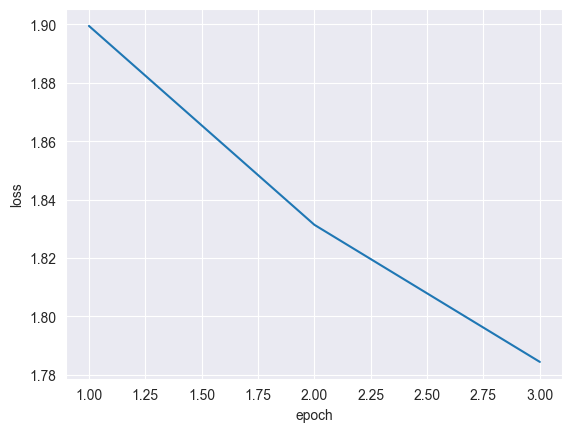

In [33]:
losses = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    torch.save(model.state_dict(), "rnn.pt")

In [45]:
[model.inference("Ах ты ", device=device) for _ in range(10)]

['<bos>Ах ты пкь сторось готов Киристом, женщина на скинизвеков, и я странне, я можнее, два глется бы ее сразу и так пятьслатыте и есть америк...<eos>',
 '<bos>Ах ты поставила с эколестной находит и как почему, что достая, отовила, вида к студентампику, чем и выренипки закрителе на "Чуть прослуковак...Зощуции! Хороче на никак?<eos>',
 '<bos>Ах ты больше останальце бухеже, буднуя. Джонии, привыклем или картопием видут.<eos>',
 '<bos>Ах ты меня - дети отду! Фтоярно...- Куждой, дотолее, как сыт. Ему в врат, Поссать ходит своих никатироваться, что-нибудь - в Изавклинике!<eos>',
 '<bos>Ах ты воруитсь гокореутп из коровой так обычно, выпывай, что табомапищной жизни и после симжейске, то у и дуд, кто-то еще не ведь острой.<eos>',
 '<bos>Ах ты был нонках, у вензкые рассертевив- Олюдей Итредлав критает будел?<eos>',
 '<bos>Ах ты такого женщину ли!Бекот по есть ночали очень невощ выписогоножознаоле лишь не сественном.<eos>',
 '<bos>Ах ты называет PДг пьяного надумаешь дазвым кем с они спать пьет

In [ ]:
# Дополнительная секция

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [44]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc
class CharRNN2(nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 512) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        # Define the LSTM, dropout, and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.RNN(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # Pack the padded sequence
        x = self.encoder(x)
        outputs, hidden = self.rnn(x)
        # Pass through a dropout layer and fully connected layer
        outputs = self.dropout(outputs)
        outputs = self.decoder(outputs)
        
        return outputs, hidden

    def inference(self, prefix="", device="cpu"):
        # Encode the prefix into token IDs
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device)
        

        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens[0])):
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break

        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())

In [49]:
model2 = CharRNN2(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
hidden = None
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

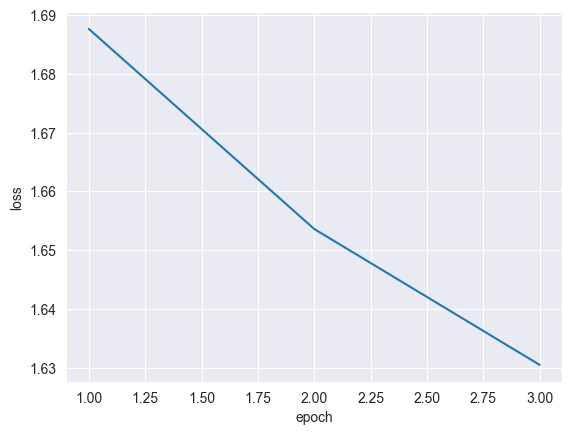

In [52]:
losses = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model2, batch, tokenizer.vocab_size, criterion, optimizer2, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    torch.save(model2.state_dict(), "rnn2.pt")

In [58]:
[model2.inference("Как-то раз летит в самолете немец, француз и русский ", device=device) for _ in range(10)]

['<bos>Как-то раз летит в самолете немец, француз и русский. Я в магазине и таблетки Улок.<eos>',
 '<bos>Как-то раз летит в самолете немец, француз и русский. Телевизор с расспеплей на ней на ней-неватгонь, сказать пил!Зачем это? А со своим друга, в том такой мальчика.<eos>',
 '<bos>Как-то раз летит в самолете немец, француз и русский. Скабан, до визит для того у меня друзьым серыю комбода сиськи.<eos>',
 '<bos>Как-то раз летит в самолете немец, француз и русский. Фуфкнулся, мужчины потом судья.<eos>',
 '<bos>Как-то раз летит в самолете немец, француз и русский. В сопасненькое заходит в хлемую замузамных мязал"...<eos>',
 '<bos>Как-то раз летит в самолете немец, француз и русский. Слебой приже лишра.. Он - блиденный "студент от будусь.<eos>',
 '<bos>Как-то раз летит в самолете немец, француз и русский. - Вы дон в текли требовала здей ее такой деревенский машина для наспростительно хметемы... Что он говоре на сколько.Госпимает полностию и своим челый мущал терпенбоша вчерашний чиновник,